In [1]:
%matplotlib inline


# Comparing edge-based and region-based segmentation


In this example, we will see how to segment objects from a background. We use
the ``coins`` image from ``skimage.data``, which shows several coins outlined
against a darker background.



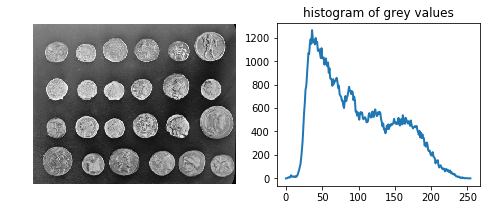

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data

coins = data.coins()
hist = np.histogram(coins, bins=np.arange(0, 256))

fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].imshow(coins, cmap=plt.cm.gray, interpolation='nearest')
axes[0].axis('off')
axes[1].plot(hist[1][:-1], hist[0], lw=2)
axes[1].set_title('histogram of grey values')

Thresholding
============

A simple way to segment the coins is to choose a threshold based on the
histogram of grey values. Unfortunately, thresholding this image gives a
binary image that either misses significant parts of the coins or merges
parts of the background with the coins:



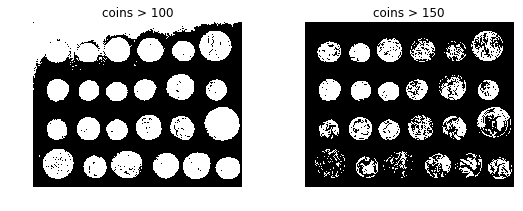

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=True)

axes[0].imshow(coins > 100, cmap=plt.cm.gray, interpolation='nearest')
axes[0].set_title('coins > 100')

axes[1].imshow(coins > 150, cmap=plt.cm.gray, interpolation='nearest')
axes[1].set_title('coins > 150')

for a in axes:
    a.axis('off')
    a.set_adjustable('box-forced')

plt.tight_layout()

Edge-based segmentation
=======================

Next, we try to delineate the contours of the coins using edge-based
segmentation. To do this, we first get the edges of features using the
Canny edge-detector.



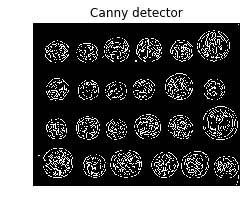

In [4]:
from skimage.feature import canny

edges = canny(coins)

fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(edges, cmap=plt.cm.gray, interpolation='nearest')
ax.set_title('Canny detector')
ax.axis('off')
ax.set_adjustable('box-forced')

These contours are then filled using mathematical morphology.



(-0.5, 383.5, 302.5, -0.5)

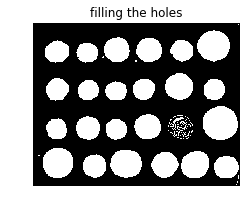

In [5]:
from scipy import ndimage as ndi

fill_coins = ndi.binary_fill_holes(edges)

fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(fill_coins, cmap=plt.cm.gray, interpolation='nearest')
ax.set_title('filling the holes')
ax.axis('off')

Small spurious objects are easily removed by setting a minimum size for
valid objects.



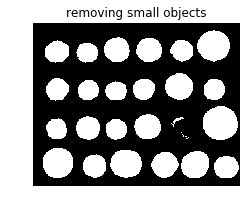

In [6]:
from skimage import morphology

coins_cleaned = morphology.remove_small_objects(fill_coins, 21)

fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(coins_cleaned, cmap=plt.cm.gray, interpolation='nearest')
ax.set_title('removing small objects')
ax.axis('off')
ax.set_adjustable('box-forced')

However, this method is not very robust, since contours that are not
perfectly closed are not filled correctly, as is the case for one unfilled
coin above.

Region-based segmentation
=========================

We therefore try a region-based method using the watershed transform.
First, we find an elevation map using the Sobel gradient of the image.



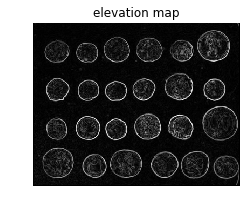

In [7]:
from skimage.filters import sobel

elevation_map = sobel(coins)

fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(elevation_map, cmap=plt.cm.gray, interpolation='nearest')
ax.set_title('elevation map')
ax.axis('off')
ax.set_adjustable('box-forced')

Next we find markers of the background and the coins based on the extreme
parts of the histogram of grey values.



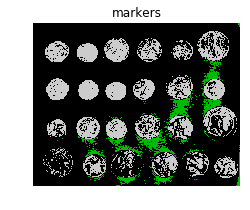

In [8]:
markers = np.zeros_like(coins)
markers[coins < 30] = 1
markers[coins > 150] = 2

fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(markers, cmap=plt.cm.spectral, interpolation='nearest')
ax.set_title('markers')
ax.axis('off')
ax.set_adjustable('box-forced')

Finally, we use the watershed transform to fill regions of the elevation
map starting from the markers determined above:



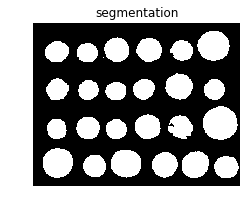

In [9]:
segmentation = morphology.watershed(elevation_map, markers)

fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(segmentation, cmap=plt.cm.gray, interpolation='nearest')
ax.set_title('segmentation')
ax.axis('off')
ax.set_adjustable('box-forced')

This last method works even better, and the coins can be segmented and
labeled individually.



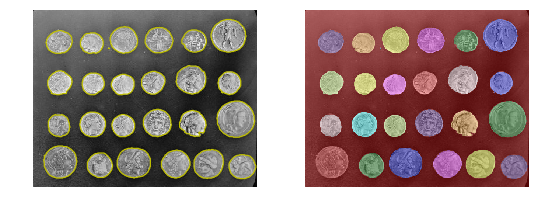

In [10]:
from skimage.color import label2rgb

segmentation = ndi.binary_fill_holes(segmentation - 1)
labeled_coins, _ = ndi.label(segmentation)
image_label_overlay = label2rgb(labeled_coins, image=coins)

fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
axes[0].imshow(coins, cmap=plt.cm.gray, interpolation='nearest')
axes[0].contour(segmentation, [0.5], linewidths=1.2, colors='y')
axes[1].imshow(image_label_overlay, interpolation='nearest')

for a in axes:
    a.axis('off')
    a.set_adjustable('box-forced')

plt.tight_layout()